In [2]:
%matplotlib inline

## Developer examples

### LI thresholding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import filters
from skimage.filters.thresholding import _cross_entropy

cell = data.cell()
camera = data.camera()

The brute force optimal threshold is: 62.5
The computed optimal threshold is: 62.97248355395971


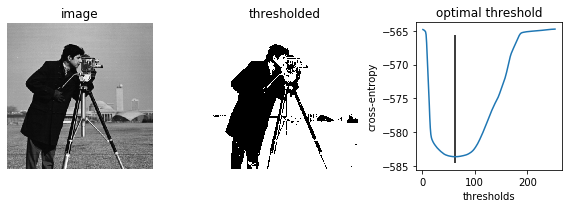

In [2]:
# plot cross-entropy for the camera image, all possible thresholds.
thresholds = np.arange(np.min(camera) + 1.5, np.max(camera) - 1.5)
entropies = [_cross_entropy(camera, t) for t in thresholds]

optimal_camera_threshold = thresholds[np.argmin(entropies)]

fig, ax = plt.subplots(1, 3, figsize=(8, 3))

ax[0].imshow(camera, cmap='gray')
ax[0].set_title('image')
ax[0].set_axis_off()

ax[1].imshow(camera > optimal_camera_threshold, cmap='gray')
ax[1].set_title('thresholded')
ax[1].set_axis_off()

ax[2].plot(thresholds, entropies)
ax[2].set_xlabel('thresholds')
ax[2].set_ylabel('cross-entropy')
ax[2].vlines(optimal_camera_threshold,
             ymin=np.min(entropies) - 0.05 * np.ptp(entropies),
             ymax=np.max(entropies) - 0.05 * np.ptp(entropies))
ax[2].set_title('optimal threshold')

fig.tight_layout()

print('The brute force optimal threshold is:', optimal_camera_threshold)
print('The computed optimal threshold is:', filters.threshold_li(camera))

plt.show()

Only 6 thresholds examined.


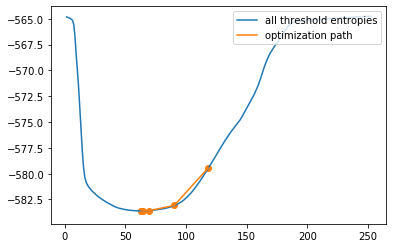

In [3]:
# use iter-callback feature to examine the optimization process.

iter_thresholds = []

optimal_threshold = filters.threshold_li(camera,
                                         iter_callback=iter_thresholds.append)

iter_entropies = [_cross_entropy(camera, t) for t in iter_thresholds]

print('Only', len(iter_thresholds), 'thresholds examined.')

fig, ax = plt.subplots()
ax.plot(thresholds, entropies, label='all threshold entropies')
ax.plot(iter_thresholds, iter_entropies, label='optimization path')
ax.scatter(iter_thresholds, iter_entropies, c='C1')
ax.legend(loc='upper right')
plt.show()

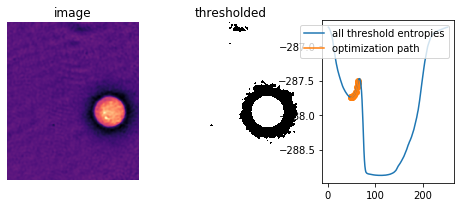

In [4]:
# cross-entropy is not convex (having a single optimum) in some images.
# so gradient descent would not be optimal.
# below: how a bad initial guess results in poor threshold selection.

iter_thresholds2 = []

opt_threshold2 = filters.threshold_li(cell, initial_guess=64,
                                      iter_callback=iter_thresholds2.append)

thresholds2     = np.arange(np.min(cell) + 1.5, np.max(cell) - 1.5)
entropies2      = [_cross_entropy(cell, t) for t in thresholds]
iter_entropies2 = [_cross_entropy(cell, t) for t in iter_thresholds2]

fig, ax = plt.subplots(1, 3, figsize=(8, 3))

ax[0].imshow(cell, cmap='magma')
ax[0].set_title('image')
ax[0].set_axis_off()

ax[1].imshow(cell > opt_threshold2, cmap='gray')
ax[1].set_title('thresholded')
ax[1].set_axis_off()

ax[2].plot(thresholds2, entropies2, label='all threshold entropies')
ax[2].plot(iter_thresholds2, iter_entropies2, label='optimization path')
ax[2].scatter(iter_thresholds2, iter_entropies2, c='C1')
ax[2].legend(loc='upper right')

plt.show()

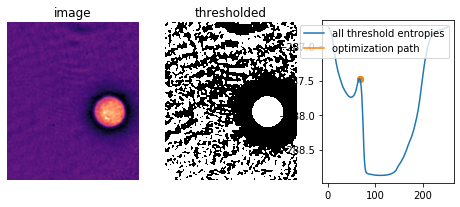

In [5]:
iter_thresholds3 = []

opt_threshold3 = filters.threshold_li(cell,
                                      iter_callback=iter_thresholds3.append)

iter_entropies3 = [_cross_entropy(cell, t) for t in iter_thresholds3]

fig, ax = plt.subplots(1, 3, figsize=(8, 3))

ax[0].imshow(cell, cmap='magma')
ax[0].set_title('image')
ax[0].set_axis_off()

ax[1].imshow(cell > opt_threshold3, cmap='gray')
ax[1].set_title('thresholded')
ax[1].set_axis_off()

ax[2].plot(thresholds2, entropies2, label='all threshold entropies')
ax[2].plot(iter_thresholds3, iter_entropies3, label='optimization path')
ax[2].scatter(iter_thresholds3, iter_entropies3, c='C1')
ax[2].legend(loc='upper right')

plt.show()

8 examined, optimum: 111.68876119648344


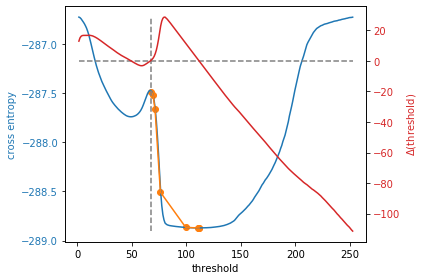

In [6]:
# define function "li_gradient" that replicates inner loop of the LI 
# and returns the chg from the current threshold to the next.
# below: show cross-entropy and LI update path when initial guess is
# on the right side of the entropy peak.
# overlay threshold update gradient, marking the 0 gradient line.

def li_gradient(image, t):
    """Find the threshold update at a given threshold."""
    foreground = image > t
    mean_fore = np.mean(image[foreground])
    mean_back = np.mean(image[~foreground])
    t_next = ((mean_back - mean_fore) /
              (np.log(mean_back) - np.log(mean_fore)))
    dt = t_next - t
    return dt


iter_thresholds4 = []
opt_threshold4 = filters.threshold_li(cell, initial_guess=68,
                                      iter_callback=iter_thresholds4.append)
iter_entropies4 = [_cross_entropy(cell, t) for t in iter_thresholds4]
print(len(iter_thresholds4), 'examined, optimum:', opt_threshold4)

gradients = [li_gradient(cell, t) for t in thresholds2]

fig, ax1 = plt.subplots()
ax1.plot(thresholds2, entropies2)
ax1.plot(iter_thresholds4, iter_entropies4)
ax1.scatter(iter_thresholds4, iter_entropies4, c='C1')
ax1.set_xlabel('threshold')
ax1.set_ylabel('cross entropy', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()
ax2.plot(thresholds2, gradients, c='C3')
ax2.hlines([0], xmin=thresholds2[0], xmax=thresholds2[-1],
           colors='gray', linestyles='dashed')
ax2.vlines(np.mean(cell), ymin=np.min(gradients), ymax=np.max(gradients),
           colors='gray', linestyles='dashed')
ax2.set_ylabel(r'$\Delta$(threshold)', color='C3')
ax2.tick_params(axis='y', labelcolor='C3')

fig.tight_layout()

plt.show()

5 examined, optimum: 111.68876119648344


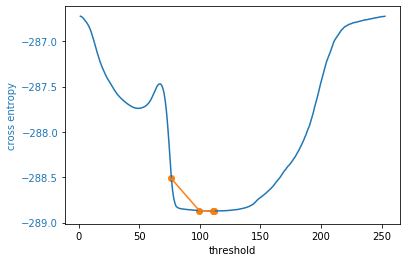

In [7]:
# skimage.filters.threshold_li() can accept a guessing function.
# good option when many images with different ranges are involved.

def quantile_95(image):
    # you can use np.quantile(image, 0.95) if you have NumPy>=1.15
    return np.percentile(image, 95)

iter_thresholds5 = []
opt_threshold5 = filters.threshold_li(cell, initial_guess=quantile_95,
                                      iter_callback=iter_thresholds5.append)
iter_entropies5 = [_cross_entropy(cell, t) for t in iter_thresholds5]
print(len(iter_thresholds5), 'examined, optimum:', opt_threshold5)

fig, ax1 = plt.subplots()
ax1.plot(thresholds2, entropies2)
ax1.plot(iter_thresholds5, iter_entropies5)
ax1.scatter(iter_thresholds5, iter_entropies5, c='C1')
ax1.set_xlabel('threshold')
ax1.set_ylabel('cross entropy', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

plt.show()

### max-tree
- hierarchical image representation - basis for many morphological filters.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from skimage.morphology import max_tree
import networkx as nx

In [9]:
# helpers
def plot_img(ax, image, title, plot_text, image_values):
    """Plot an image, overlaying image values or indices."""
    ax.imshow(image, cmap='gray', aspect='equal', vmin=0, vmax=np.max(image))
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

    for x in np.arange(-0.5, image.shape[0], 1.0):
        ax.add_artist(Line2D((x, x), (-0.5, image.shape[0] - 0.5),
                             color='blue', linewidth=2))

    for y in np.arange(-0.5, image.shape[1], 1.0):
        ax.add_artist(Line2D((-0.5, image.shape[1]), (y, y),
                             color='blue', linewidth=2))

    if plot_text:
        for i, j in np.ndindex(*image_values.shape):
            ax.text(j, i, image_values[i, j], fontsize=8,
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='red')
    return


def prune(G, node, res):
    """Transform a canonical max tree to a max tree."""
    value = G.nodes[node]['value']
    res[node] = str(node)
    preds = [p for p in G.predecessors(node)]
    for p in preds:
        if (G.nodes[p]['value'] == value):
            res[node] += ', %i' % p
            G.remove_node(p)
        else:
            prune(G, p, res)
    G.nodes[node]['label'] = res[node]
    return


def accumulate(G, node, res):
    """Transform a max tree to a component tree."""
    total = G.nodes[node]['label']
    parents = G.predecessors(node)
    for p in parents:
        total += ', ' + accumulate(G, p, res)
    res[node] = total
    return total


def position_nodes_for_max_tree(G, image_rav, root_x=4, delta_x=1.2):
    """Set the position of nodes of a max-tree.

    This function helps to visually distinguish between nodes at the same
    level of the hierarchy and nodes at different levels.
    """
    pos = {}
    for node in reversed(list(nx.topological_sort(canonical_max_tree))):
        value = G.nodes[node]['value']
        if canonical_max_tree.out_degree(node) == 0:
            # root
            pos[node] = (root_x, value)

        in_nodes = [y for y in canonical_max_tree.predecessors(node)]

        # place the nodes at the same level
        level_nodes = [y for y in
                       filter(lambda x: image_rav[x] == value, in_nodes)]
        nb_level_nodes = len(level_nodes) + 1

        c = nb_level_nodes // 2
        i = - c
        if (len(level_nodes) < 3):
            hy = 0
            m = 0
        else:
            hy = 0.25
            m = hy / (c - 1)

        for level_node in level_nodes:
            if(i == 0):
                i += 1
            if (len(level_nodes) < 3):
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x, value)
            else:
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x,
                                   value + m * (2 * np.abs(i) - c - 1))
            i += 1

        # place the nodes at different levels
        other_level_nodes = [y for y in
                             filter(lambda x: image_rav[x] > value, in_nodes)]
        if (len(other_level_nodes) == 1):
            i = 0
        else:
            i = - len(other_level_nodes) // 2
        for other_level_node in other_level_nodes:
            if((len(other_level_nodes) % 2 == 0) and (i == 0)):
                i += 1
            pos[other_level_node] = (pos[node][0] + i * delta_x,
                                     image_rav[other_level_node])
            i += 1

    return pos


def plot_tree(graph, positions, ax, *, title='', labels=None,
              font_size=8, text_size=8):
    """Plot max and component trees."""
    nx.draw_networkx(graph, pos=positions, ax=ax,
                     node_size=40, node_shape='s', node_color='white',
                     font_size=font_size, labels=labels)
    xlimit = ax.get_xlim()
    for v in range(image_rav.min(), image_rav.max() + 1):
        ax.hlines(v - 0.5, -3, 10, linestyles='dotted')
        ax.text(-3, v - 0.15, "val: %i" % v, fontsize=text_size)
    ax.hlines(v + 0.5, -3, 10, linestyles='dotted')
    ax.set_xlim(-3, 10)
    ax.set_title(title)
    ax.set_axis_off()

In [10]:
# test image
image = np.array([[40, 40, 39, 39, 38],
                  [40, 41, 39, 39, 39],
                  [30, 30, 30, 32, 32],
                  [33, 33, 30, 32, 35],
                  [30, 30, 30, 33, 36]], dtype=np.uint8)

In [11]:
# max-tree
P, S = max_tree(image)
P_rav = P.ravel()

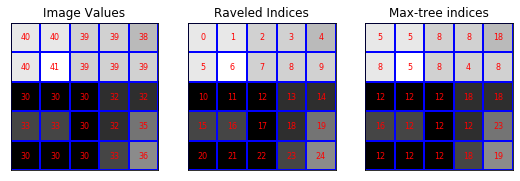

In [12]:
# plot image and its raveled indices
# raveled image
image_rav = image.ravel()

# raveled indices of the example image (for display purpose)
raveled_indices = np.arange(image.size).reshape(image.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9, 3))

plot_img(ax1, image - image.min(), 'Image Values',
         plot_text=True, image_values=image)

plot_img(ax2, image - image.min(), 'Raveled Indices',
         plot_text=True, image_values=raveled_indices)

plot_img(ax3, image - image.min(), 'Max-tree indices',
         plot_text=True, image_values=P)


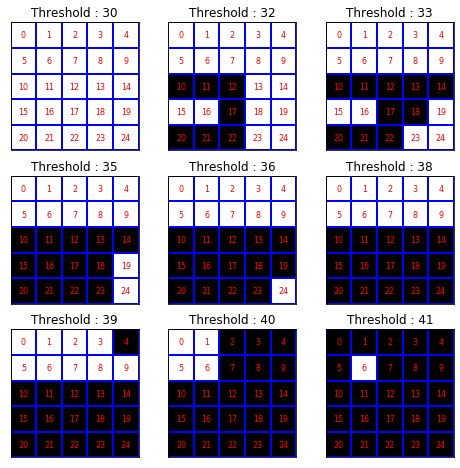

In [14]:
# visualize threshold ops
fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(8,8))
thresholds = np.unique(image)

for k, threshold in enumerate(thresholds):
    bin_img = image >= threshold
    plot_img(
        axes[(k//3), (k%3)], 
        bin_img, 
        'Threshold : %i' % threshold,
        plot_text=True, 
        image_values=raveled_indices)

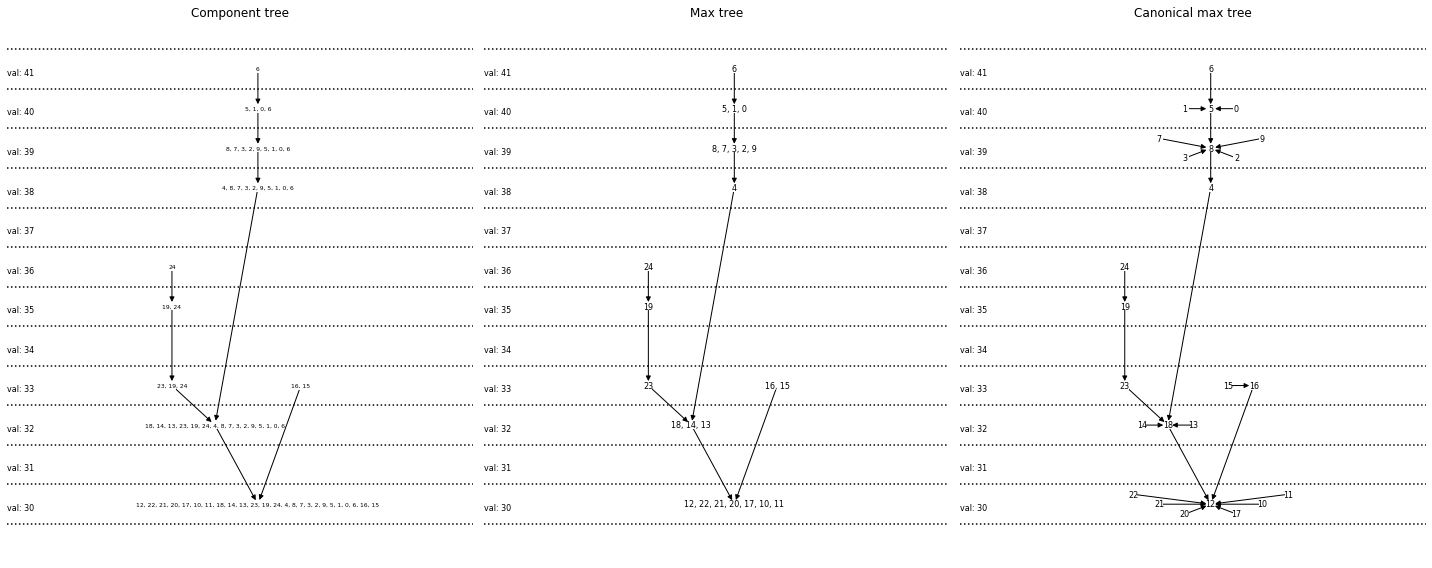

In [15]:
# max-tree plots

# the canonical max-tree graph
canonical_max_tree = nx.DiGraph()
canonical_max_tree.add_nodes_from(S)
for node in canonical_max_tree.nodes():
    canonical_max_tree.nodes[node]['value'] = image_rav[node]
canonical_max_tree.add_edges_from([(n, P_rav[n]) for n in S[1:]])

# max-tree from the canonical max-tree
nx_max_tree = nx.DiGraph(canonical_max_tree)
labels = {}
prune(nx_max_tree, S[0], labels)

# component tree from the max-tree
labels_ct = {}
total = accumulate(nx_max_tree, S[0], labels_ct)

# positions of nodes : canonical max-tree (CMT)
pos_cmt = position_nodes_for_max_tree(canonical_max_tree, image_rav)

# positions of nodes : max-tree (MT)
pos_mt = dict(zip(nx_max_tree.nodes, [pos_cmt[node]
                                      for node in nx_max_tree.nodes]))

# plot the trees with networkx and matplotlib
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 8))

plot_tree(nx_max_tree,        pos_mt,  ax1, title='Component tree', labels=labels_ct, font_size=6, text_size=8)
plot_tree(nx_max_tree,        pos_mt,  ax2, title='Max tree',       labels=labels)
plot_tree(canonical_max_tree, pos_cmt, ax3, title='Canonical max tree')

fig.tight_layout()
plt.show()
